# ***Plane crashes throughout history***

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/PenAir_Flight_3296%EF%BC%88N686PA%EF%BC%89_after_crash_landing.jpg)

# Installation and import

We start by installing and importing necessary libraries.

In [ ]:
!pip install fancyimpute

In [ ]:
!pip install missingpy

In [ ]:
!pip install plotly==5.3.1

In [ ]:
!pip install kaleido

In [ ]:
!pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import plotly.express as px

(CVXPY) Jan 04 06:39:43 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) Jan 04 06:39:43 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) Jan 04 06:39:43 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')


# Data wrangling

In [ ]:
data = pd.read_csv('Plane Crashes.csv')
data.head()

,Date,Time,Aircraft,Operator,Registration,Flight phase,Flight type,Survivors,Crash site,Schedule,...,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
0,1918-05-02,NaN,De Havilland DH.4,United States Signal Corps - USSC,AS-32084,Takeoff (climb),Test,No,Airport (less than 10 km from airport),Dayton - Dayton,...,United States of America,North America,2.0,2.0,0.0,0.0,0.0,2,The single engine airplane departed Dayton-McC...,Technical failure
1,1918-06-08,NaN,Handley Page V/1500,Handley Page Aircraft Company Ltd,E4104,Takeoff (climb),Test,Yes,Airport (less than 10 km from airport),Cricklewood - Cricklewood,...,United Kingdom,Europe,6.0,5.0,0.0,0.0,0.0,5,"Assembled at Cricklewood Airfield in May 1918,...",Technical failure
2,1918-06-11,NaN,Avro 504,Royal Air Force - RAF,A8544,Flight,Training,Yes,"Plain, Valley",Abukir - Abukir,...,Egypt,Africa,2.0,1.0,0.0,0.0,0.0,1,The single engine aircraft was completing a lo...,Unknown
3,1918-06-19,NaN,De Havilland DH.4,United States Signal Corps - USSC,AS-32098,Flight,Military,No,Airport (less than 10 km from airport),Wright Patterson AFB-Wright Patterson AFB,...,United States of America,North America,1.0,1.0,0.0,0.0,0.0,1,"Lt. Frank Stuart Patterson, son and nephew of ...",Technical failure
4,1918-06-24,NaN,Breguet 14,French Air Force - Armée de l'Air,AS-4130,Landing (descent or approach),Military,Yes,NaN,NaN,...,France,Europe,NaN,0.0,NaN,0.0,0.0,0,The aircraft crashed iupon landing somewhere i...,Unknown


**Columns (some are self explanatory)**

* ```Date```
* ```Time```
* ```Aircraft```: Aircraft model.
* ```Operator```: Airline operator.
* ```Registration```: Aircraft plate.
* ```Flight phase```: Flight phase at the time of the accident.
* ```Flight type```: charter/taxi, military, cargo or even ilegal.
* ```Survivors```: Boolean type.
* ```Crash site```: Categorical, not geografical.
* ```Schedule```: Destination.
* ```MSN```: Manufacturer serial number, probably not useful to our analysis.
* ```YOM```: Year of making.
* ```Flight no.```
* ```Crash location```
* ```Country```
* ```Region```: Continent.
* ```Crew on board```
* ```Crew fatalities```
* ```Pax on board```
* ```PAX fatalities```
* ```Other fatalities```
* ```Total fatalities```
* ```Circumstances```: Short description of the accident.
* ```Crash cause```

In [ ]:
data.shape

(28536, 24)

There are many columns with null values.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28536 entries, 0 to 28535
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28536 non-null  object 
 1   Time              13949 non-null  object 
 2   Aircraft          28535 non-null  object 
 3   Operator          28536 non-null  object 
 4   Registration      27721 non-null  object 
 5   Flight phase      27898 non-null  object 
 6   Flight type       28479 non-null  object 
 7   Survivors         27239 non-null  object 
 8   Crash site        28153 non-null  object 
 9   Schedule          19590 non-null  object 
 10  MSN               24354 non-null  object 
 11  YOM               23225 non-null  float64
 12  Flight no.        0 non-null      float64
 13  Crash location    28524 non-null  object 
 14  Country           28535 non-null  object 
 15  Region            28535 non-null  object 
 16  Crew on board     28512 non-null  float6

In [ ]:
data.isna().sum()

Date                    0
Time                14587
Aircraft                1
Operator                0
Registration          815
Flight phase          638
Flight type            57
Survivors            1297
Crash site            383
Schedule             8946
MSN                  4182
YOM                  5311
Flight no.          28536
Crash location         12
Country                 1
Region                  1
Crew on board          24
Crew fatalities         1
Pax on board           54
PAX fatalities          1
Other fatalities       10
Total fatalities        0
Circumstances          25
Crash cause             0
dtype: int64

We drop one column which has too many null values (```Time```), and others which don't provide us any useful information (```Registration```, ```MSN```, ```Flight no.```). We then check % nulls, for columns that have them.

In [ ]:
data.drop(['Time', 'Registration', 'MSN', 'Flight no.'], axis=1, inplace=True)

null=(data.isnull().sum()/data.shape[0])*100
null=null.sort_values(ascending=False)
null= null[null>0]
null

Schedule            31.349874
YOM                 18.611578
Survivors            4.545136
Flight phase         2.235772
Crash site           1.342164
Flight type          0.199748
Pax on board         0.189235
Circumstances        0.087609
Crew on board        0.084104
Crash location       0.042052
Other fatalities     0.035043
Region               0.003504
Aircraft             0.003504
Crew fatalities      0.003504
PAX fatalities       0.003504
Country              0.003504
dtype: float64

We check the row where ```Aircraft``` (model) is null.

In [ ]:
data[data['Aircraft'].isnull()]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
2812,1936-06-19,NaN,Universal Air Industries,Takeoff (climb),Private,NaN,Airport (less than 10 km from airport),NaN,1928.0,Foxwarren Manitoba,Canada,North America,0.0,0.0,0.0,0.0,0.0,0,"Shortly after takeoff, while climbing, the air...",Unknown


We impute it with the mode for the previous 30 accidents.

In [ ]:
data.iloc[data[data['Aircraft'].isnull()].index[0], 1] = data.iloc[data[data['Aircraft'].isnull()].index[0] - 30 : data[data['Aircraft'].isnull()].index[0], 1].mode()[0]

We inspect the distribution for the ```YOM``` column (Year of Making).

In [ ]:
data.YOM.describe()

count    23225.000000
mean      1931.942519
std        285.486067
min          0.000000
25%       1944.000000
50%       1958.000000
75%       1974.000000
max      19567.000000
Name: YOM, dtype: float64

We detect some unusually high and low impossible values. We start by inspecting the high ones.

In [ ]:
data[data['YOM'] > 2023]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
3925,1940-10-23,De Havilland DH.60 Moth,Toronto Flying Club,Landing (descent or approach),Training,Yes,Airport (less than 10 km from airport),Toronto - Toronto,12928.0,Toronto Ontario,Canada,North America,1.0,0.0,0.0,0.0,0.0,0,"The pilot, sole on board, was performing a tra...",Unknown
10003,1952-01-16,Fairchild C-119 Flying Boxcar,United States Air Force - USAF,Flight,Supply,Yes,"Lake, Sea, Ocean, River",Pohang – Seoul,14949.0,Gampo North Gyeongsang (<U+ACBD><U+C0C1><U+BD8...,South Korea,Asia,5.0,3.0,0.0,0.0,0.0,3,"While cruising along the coast, the crew encou...",Technical failure
18364,1979-02-12,Vickers Viscount,Air Rhodesia,Takeoff (climb),Scheduled Revenue Flight,No,Airport (less than 10 km from airport),Kariba - Salisbury,19567.0,Kariba Mashonaland West,Zimbabwe,Africa,5.0,5.0,54.0,54.0,0.0,59,"Shortly after takeoff from Kariba Airport, whi...","Terrorism act, Hijacking, Sabotage"


Many of these inconsistencies are usually typos, so we search online for plane models and correct them according to their datasheets.

In [ ]:
data.iloc[3925, 8] = 1928
data.iloc[10003, 8] = 1949
data.iloc[18364, 8] = 1967

There are many 2 digit records, which is impossible since the first airplane was designed in 1903 (Wright brothers) and the first registered crash doesn't ocurr until 1918. So for those, we will add 1900 to obtain a reasonable record.

In [ ]:
data.loc[data['YOM'] <= 99, 'YOM'] = data.loc[data['YOM'] <= 99, 'YOM'].apply(lambda x: x + 1900)

We subset for ```YOM``` prior to 1910.

In [ ]:
data[data['YOM'] < 1910]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,Country,Region,Crew on board,Crew fatalities,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause
673,1926-01-15,Avro 504,Royal Netherlands East Indies Air Force - ML-KNIL,Flight,Training,No,Airport (less than 10 km from airport),Kalijati - Kalijati,1901.0,Kalijati West Java,Indonesia,Asia,1.0,0.0,0.0,0.0,0.0,0,"The pilot, sole on board, was completing a loc...",Unknown
2763,1936-03-31,Ford 5,China National Aviation Corporation - CNAC,Landing (descent or approach),Cargo,Yes,Airport (less than 10 km from airport),Hankow - Shanghai,1907.0,Nankin Jiangsu,China,Asia,2.0,0.0,0.0,0.0,0.0,0,Crew was performing a cargo flight from Hankow...,Technical failure
2875,1936-09-15,Avro 504,Royal Air Force - RAF,Flight,Military,Yes,Mountains,Hendon – Abbotsinch,1909.0,Carlton-in-Cleveland Yorkshire,United Kingdom,Europe,1.0,0.0,0.0,0.0,0.0,0,The aircraft was being ferried from Hendon to ...,Human factor
2898,1936-10-26,Caudron C.440 Goéland,Air Bleu,Landing (descent or approach),Postal (mail),Yes,Airport (less than 10 km from airport),Paris – Saigon,1900.0,Karachi Sindh (<U+0633><U+0646><U+068C> <U+063...,Pakistan,Asia,3.0,0.0,0.0,0.0,0.0,0,Crashed on landing in unknown circumstances. A...,Unknown
2901,1936-11-02,De Havilland DH.89 Dragon Rapide,Northern %26 Scottish Airways,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),NaN,1900.0,Glasgow Strathclyde,United Kingdom,Europe,1.0,0.0,7.0,0.0,0.0,0,Crashed on takeoff in unknown circumstances at...,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15675,1971-07-15,PZL-Mielec AN-2,Aeroflot - Russian International Airlines,Flight,Spraying (Agricultural),No,"Plain, Valley",Pochep - Pochep,1902.0,Pochep Bryansk oblast,Russia,Asia,2.0,2.0,0.0,0.0,0.0,2,The crew was engaged in a crop spraying missio...,Human factor
17595,1977-02-28,Dornier DO.28D Skyservant,German Air Force - Deutsche Luftwaffe,NaN,Military,Yes,Airport (less than 10 km from airport),NaN,1900.0,Kaufbeuren AFB Bavaria,Germany,Europe,0.0,0.0,0.0,0.0,0.0,0,At least was crew was injured when the airplan...,Unknown
18426,1979-04-16,Convair CV-440 Metropolitan,Jose Benitez,Landing (descent or approach),Private,Yes,Airport (less than 10 km from airport),Key West - Key West,254.0,Key West-Intl Florida,United States of America,North America,2.0,0.0,0.0,0.0,0.0,0,The crew departed Key West-Intl Airport for a ...,Technical failure
20732,1986-07-31,Fletcher FU-24,Rural Aerial co-op,Flight,Spraying (Agricultural),Yes,"Plain, Valley",NaN,1901.0,Ihuraua Manawatu-Wanganui (Horizons Regional C...,New Zealand,Oceania,0.0,0.0,0.0,0.0,0.0,0,Crashed in unknown circumstances while complet...,Unknown


We then Google-search the models, check manufacturing years, and correct accordingly; assuming typos again. This is repeated for all entries.

In [ ]:
data.iloc[673, 8] = 1921
data.iloc[2763, 8] = 1927
data.iloc[2875, 8] = 1929
data.iloc[2898, 8] = 1935
data.iloc[2901, 8] = 1934
data.iloc[2932, 8] = 1930
data.iloc[3104, 8] = 1930
data.iloc[3351, 8] = 1928
data.iloc[4018, 8] = 1931
data.iloc[4114, 8] = 1932
data.iloc[4226, 8] = 1925
data.iloc[4254, 8] = 1933
data.iloc[4543, 8] = 1940
data.iloc[4656, 8] = 1931
data.iloc[4960, 8] = 1925
data.iloc[4987, 8] = 1942
data.iloc[5018, 8] = 1940
data.iloc[5091, 8] = 1936
data.iloc[5532, 8] = 1939
data.iloc[5627, 8] = 1943
data.iloc[5824, 8] = 1940
data.iloc[5885, 8] = 1939
data.iloc[5956, 8] = 1940
data.iloc[5963, 8] = 1942
data.iloc[5972, 8] = 1940
data.iloc[6110, 8] = 1941
data.iloc[6117, 8] = 1937
data.iloc[6387, 8] = 1944
data.iloc[6392, 8] = 1930
data.iloc[6770, 8] = 1938
data.iloc[6834, 8] = 1940
data.iloc[6852, 8] = 1945
data.iloc[6994, 8] = 1940
data.iloc[7095, 8] = 1944
data.iloc[7098, 8] = 1945
data.iloc[7222, 8] = 1940
data.iloc[7403, 8] = 1943
data.iloc[7549, 8] = 1940
data.iloc[7598, 8] = 1940
data.iloc[7658, 8] = 1940
data.iloc[7720, 8] = 1946
data.iloc[7722, 8] = 1928
data.iloc[7818, 8] = 1940
data.iloc[7882, 8] = 1944
data.iloc[7890, 8] = 1940
data.iloc[8124, 8] = 1940
data.iloc[8156, 8] = 1946
data.iloc[8325, 8] = 1940
data.iloc[8464, 8] = 1948
data.iloc[8577, 8] = 1947
data.iloc[8582, 8] = 1940
data.iloc[8586, 8] = 1945
data.iloc[8608, 8] = 1945
data.iloc[8620, 8] = 1940
data.iloc[8969, 8] = 1949
data.iloc[8982, 8] = 1948
data.iloc[9001, 8] = 1942
data.iloc[9260, 8] = 1946
data.iloc[9288, 8] = 1950
data.iloc[9506, 8] = 1941
data.iloc[9604, 8] = 1940
data.iloc[9611, 8] = 1946
data.iloc[9635, 8] = 1947
data.iloc[9843, 8] = 1946
data.iloc[10065, 8] = 1947
data.iloc[10138, 8] = 1940
data.iloc[10554, 8] = 1949
data.iloc[10617, 8] = 1929
data.iloc[10659, 8] = 1948
data.iloc[10758, 8] = 1943
data.iloc[10764, 8] = 1951
data.iloc[10779, 8] = 1948
data.iloc[10878, 8] = 1948
data.iloc[11131, 8] = 1952
data.iloc[11241, 8] = 1947
data.iloc[11279, 8] = 1940
data.iloc[11376, 8] = 1950
data.iloc[11422, 8] = 1952
data.iloc[11507, 8] = 1952
data.iloc[11519, 8] = 1952
data.iloc[11572, 8] = 1957
data.iloc[11589, 8] = 1946
data.iloc[11623, 8] = 1956
data.iloc[11689, 8] = 1954
data.iloc[11712, 8] = 1951
data.iloc[11885, 8] = 1957
data.iloc[11991, 8] = 1955
data.iloc[12033, 8] = 1951
data.iloc[12123, 8] = 1958
data.iloc[12156, 8] = 1954
data.iloc[12280, 8] = 1955
data.iloc[12308, 8] = 1940
data.iloc[12406, 8] = 1960
data.iloc[12427, 8] = 1957
data.iloc[12429, 8] = 1956
data.iloc[12436, 8] = 1950
data.iloc[12685, 8] = 1960
data.iloc[12834, 8] = 1947
data.iloc[12841, 8] = 1954
data.iloc[12876, 8] = 1940
data.iloc[12883, 8] = 1960
data.iloc[12979, 8] = 1958
data.iloc[13028, 8] = 1962
data.iloc[13045, 8] = 1956
data.iloc[13097, 8] = 1940
data.iloc[13181, 8] = 1952
data.iloc[13187, 8] = 1948
data.iloc[13217, 8] = 1960
data.iloc[14447, 8] = 1949
data.iloc[15614, 8] = 1952
data.iloc[15675, 8] = 1952
data.iloc[17595, 8] = 1970
data.iloc[18426, 8] = 1964
data.iloc[20732, 8] = 1961
data.iloc[26405, 8] = 1990

We recheck the distribution for ```YOM```, which now seems reasonable.

In [ ]:
data.YOM.describe()

count    23225.000000
mean      1958.628805
std         19.840473
min       1910.000000
25%       1944.000000
50%       1958.000000
75%       1974.000000
max       2020.000000
Name: YOM, dtype: float64

We extract year, month and weekday from the date of the crash; and create a new column (```Age```) for the age of the plane at the time of it  (difference between ```Year``` and ```YOM```).

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month_name()
data['Weekday'] = data.Date.dt.day_name()

data['Age'] = data['Year'] - data['YOM']

We check the distribution for the ```Age``` column and find negative values and unusually high ones, which doesn't make sense.

In [ ]:
data.Age.describe()

count    23225.000000
mean        13.476771
std         12.697930
min         -9.000000
25%          3.000000
50%         10.000000
75%         21.000000
max        100.000000
Name: Age, dtype: float64

We subset for negative values.

In [ ]:
data[data['Age'] < 0]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age
301,1921-07-06,Avro 548,McCall-Hanrahan Air Service,Takeoff (climb),Private,NaN,Airport (less than 10 km from airport),NaN,1923.0,Ardmore Alberta,...,0.0,0.0,0.0,0,Crashed on takeoff. Crew fate unknown.,Unknown,1921,July,Wednesday,-2.0
1121,1928-12-23,Fairchild FC-2,Interstate Airlines,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Chattanooga – Atlanta,1929.0,Chattanooga Tennessee,...,4.0,3.0,0.0,4,Shortly after takeoff from Chattanooga Airport...,Unknown,1928,December,Sunday,-1.0
2301,1933-12-05,General Aircraft ST-4 Monospar,Mary du Caurroy,Flight,Private,Yes,"Plain, Valley",NaN,1935.0,Lidlington Bedfordshire,...,1.0,0.0,0.0,1,The airplane departed Woburn Abbey on a joyrid...,Human factor,1933,December,Tuesday,-2.0
2507,1934-12-03,Airspeed AS.6 Envoy,Charles T. P. Ulm,Flight,Private,No,"Lake, Sea, Ocean, River",Vancouver – San Francisco – Oakland – Honolulu...,1935.0,Pacific Ocean All World,...,0.0,0.0,0.0,3,The crew was attempting a new record over the ...,Technical failure,1934,December,Monday,-1.0
4573,1942-05-08,Lockheed C-60 LodeStar,Royal Canadian Air Force - RCAF,Landing (descent or approach),Cargo,No,Airport (less than 10 km from airport),Moncton – Gander,1943.0,Gander Newfoundland & Labrador,...,0.0,0.0,0.0,3,"Lodestar 557 departed Moncton. New Brunswick, ...",Human factor,1942,May,Friday,-1.0
4983,1942-12-06,Lockheed L-414 Hudson,Royal Air Force - RAF,Takeoff (climb),Delivery,No,Airport (less than 10 km from airport),NaN,1943.0,Gander Newfoundland & Labrador,...,0.0,0.0,0.0,4,"One minute after takeoff from Gander Airport, ...",Unknown,1942,December,Sunday,-1.0
8205,1947-08-13,Lisunov LI-2,TARS - Transporturile Aeriene Româno-Sovietice,Landing (descent or approach),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Constanta – Bucharest,1951.0,Bucharest-Baneasa Bucure<U+0219>ti,...,5.0,3.0,0.0,3,Crashed on final approach to Bucharest-Baneasa...,Unknown,1947,August,Wednesday,-4.0
9026,1949-11-14,Lisunov LI-2,Maszovlet,Landing (descent or approach),Scheduled Revenue Flight,Yes,Mountains,Budaörs – Pécs,1951.0,Pécs Baranya,...,1.0,1.0,0.0,6,The aircraft left Budaörs Airport (west of Bud...,Human factor,1949,November,Monday,-2.0
9153,1950-03-29,Lisunov LI-2,LOT Polish Airlines - Polskie Linie Lotnicze,Landing (descent or approach),Scheduled Revenue Flight,NaN,Airport (less than 10 km from airport),NaN,1951.0,Poland All Poland,...,0.0,0.0,0.0,0,Crash landed on an airport somewhere in Poland.,Unknown,1950,March,Wednesday,-1.0
9410,1950-11-15,Lisunov LI-2,TARS - Transporturile Aeriene Româno-Sovietice,Flight,Scheduled Revenue Flight,NaN,Mountains,NaN,1951.0,Fagara<U+0219> Mountains Arge<U+0219>,...,0.0,0.0,0.0,0,Crashed in unknown circumstances in the Fagara...,Unknown,1950,November,Wednesday,-1.0


We repeat the previous process: Google-search the models, check manufacturing years, and correct ```YOM``` accordingly assuming typos (```YOM``` can't be higher than ```Year```). This is repeated for all entries.

In [ ]:
data.iloc[301, 8] = 1920
data.iloc[1121, 8] = 1926
data.iloc[2301, 8] = 1932
data.iloc[2507, 8] = 1934
data.iloc[4573, 8] = 1942
data.iloc[4983, 8] = 1942
data.iloc[8205, 8] = 1941
data.iloc[9026, 8] = 1941
data.iloc[9153, 8] = 1941
data.iloc[9410, 8] = 1941
data.iloc[11139, 8] = 1949
data.iloc[13264, 8] = 1961
data.iloc[15507, 8] = 1969
data.iloc[16109, 8] = 1967
data.iloc[17769, 8] = 1969
data.iloc[18092, 8] = 1970
data.iloc[18977, 8] = 1977
data.iloc[19397, 8] = 1972
data.iloc[19975, 8] = 1974

We subset for high values.

In [ ]:
data[data['Age'] > 80].sort_values('Age')

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age
26628,2009-11-14,Travel Air 4000,Low %26 Slow Aviation Ventures,Landing (descent or approach),Demonstration,Yes,Airport (less than 10 km from airport),Fort Myers - Fort Myers,1927.0,Fort Myers-Page Field Florida,...,2.0,0.0,0.0,0,"During approach, the pilot of the tailwheel-eq...",Human factor,2009,November,Saturday,82.0
27306,2013-08-12,De Havilland DH.60 Moth,Private British,Flight,Private,Yes,"Plain, Valley",Turweston - Turweston,1930.0,Canons Ashby Northamptonshire,...,1.0,0.0,0.0,0,The pilot was carrying out a local flight with...,Technical failure,2013,August,Monday,83.0
27457,2014-07-02,Fokker 50,Skyward International Aviation,Takeoff (climb),Cargo,No,City,Nairobi - Mogadishu,1926.0,Nairobi-Jomo Kenyatta (ex Embakasi) Nairobi Ci...,...,2.0,2.0,0.0,4,"On 2 July 2014, about 01.14 UTC, 5Y-CET, a Fok...",Human factor,2014,July,Wednesday,88.0
27731,2016-03-02,Travel Air 4000,Daniel J. Murray,Flight,Private,No,"Plain, Valley",Longmont – Casa Grande,1928.0,Palmer Lake Colorado,...,1.0,1.0,0.0,2,The commercial pilot and the pilot-rated passe...,Human factor,2016,March,Wednesday,88.0
27539,2015-01-02,Saab 340,FlyBe,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Stornoway – Glasgow,1923.0,Stornoway Hebrides Islands,...,26.0,0.0,0.0,0,The aircraft had been prepared for a Commercia...,Weather,2015,January,Friday,92.0
27502,2014-10-12,BAe Jetstream 31,Air Century,Landing (descent or approach),Charter/Taxi (Non Scheduled Revenue Flight),Yes,Airport (less than 10 km from airport),San Juan - Punta Cana,1918.0,Punta Cana La Altagracia,...,10.0,0.0,0.0,0,The twin engine aircraft departed San Juan-Lui...,Technical failure,2014,October,Sunday,96.0
27749,2016-04-03,PZL-Mielec AN-2,Technoservis-A,Takeoff (climb),Spraying (Agricultural),Yes,"Plain, Valley",Aksarino - Aksarino,1916.0,Aksarino Republic of Tatarstan,...,0.0,0.0,0.0,0,"The pilot, sole on board, was engaged in a cro...",Human factor,2016,April,Sunday,100.0


We repeat the process one more time: Google-search the models, check manufacturing years and correct ```YOM``` accordingly assuming typos (only for some of them). Upon search, we  found a couple of very old planes which still fly; this doesn't seem to be an error accounting for those plane models' manufacturing years.

We recalculate the ```Age``` column.

In [ ]:
data.iloc[27749, 8] = 1956
data.iloc[27502, 8] = 1981
data.iloc[27539, 8] = 1983
data.iloc[27457, 8] = 1986

data['Age'] = data['Year'] - data['YOM']

And inspect it's distribution, which appears reasonable.

In [ ]:
data.Age.describe()

count    23225.000000
mean        13.472982
std         12.653534
min          0.000000
25%          3.000000
50%         10.000000
75%         21.000000
max         88.000000
Name: Age, dtype: float64

For all categorical columns, we replace null values with new categories: 'Unknown', 'None' or 'Other'.

In [ ]:
data['Flight phase'].replace(np.nan, 'Unknown', inplace=True)
data['Flight type'].replace(np.nan, 'Other', inplace=True)
data['Survivors'].replace(np.nan, 'Unknown', inplace=True)
data['Crash site'].replace(np.nan, 'Unknown', inplace=True)
data['Schedule'].replace(np.nan, 'Unknown', inplace=True)
data['Crash location'].replace(np.nan, 'Unknown', inplace=True)
data['Country'].replace(np.nan, 'None', inplace=True)
data['Country'].replace('World', 'None', inplace=True)
data['Region'].replace(np.nan, 'Other', inplace=True)
data['Region'].replace('World','Other', inplace=True)
data['Circumstances'].replace(np.nan, 'Unknown', inplace=True)

### IterativeImputer

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28536 entries, 0 to 28535
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              28536 non-null  datetime64[ns]
 1   Aircraft          28536 non-null  object        
 2   Operator          28536 non-null  object        
 3   Flight phase      28536 non-null  object        
 4   Flight type       28536 non-null  object        
 5   Survivors         28536 non-null  object        
 6   Crash site        28536 non-null  object        
 7   Schedule          28536 non-null  object        
 8   YOM               23225 non-null  float64       
 9   Crash location    28536 non-null  object        
 10  Country           28536 non-null  object        
 11  Region            28536 non-null  object        
 12  Crew on board     28512 non-null  float64       
 13  Crew fatalities   28535 non-null  float64       
 14  Pax on board      2848

We will make a comparisson by applying different imputer-models, in order to predict the remaining missing values.

A feature column is designated as output (y) and the selected ones are treated as input (x). A regressor is fit on (x, y) and is used to predict the missing values of y. This is done for each feature in an iterative fashion for the selected subset.

In [ ]:
labelencoder = LabelEncoder()
data['Aircraft'] = data['Aircraft'].astype('str')
data['Aircraft_cod'] = labelencoder.fit_transform(data['Aircraft'])

In [ ]:
mice_impute = IterativeImputer()
traindatafill = mice_impute.fit_transform(data[['Age', 'YOM', 'Aircraft_cod']])
traindatafill= pd.DataFrame(traindatafill)

c:\Users\leann\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


### MissForest

We repeat the process applying another model.

In [ ]:
imputer = MissForest(criterion='squared_error')
imputed = imputer.fit_transform(data[['YOM', 'Crew on board', 'Crew fatalities', 'Pax on board', 'PAX fatalities',
                                     'Other fatalities', 'Total fatalities', 'Year']])
data_imp = pd.DataFrame(imputed)


c:\Users\leann\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\leann\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Iteration: 0
Iteration: 1
Iteration: 2


We plot the ```YOM``` columns for the original and the imputed versions.

On the left, we can see the original data with its missing values.
On the center, the IterativeImputer algorithm assumed a normal distribution and imputed with the mean, modifying the original distribution.
Finally, on the right, the MissForest algorithm was the closest to the original distribution, making it the preferred choice.

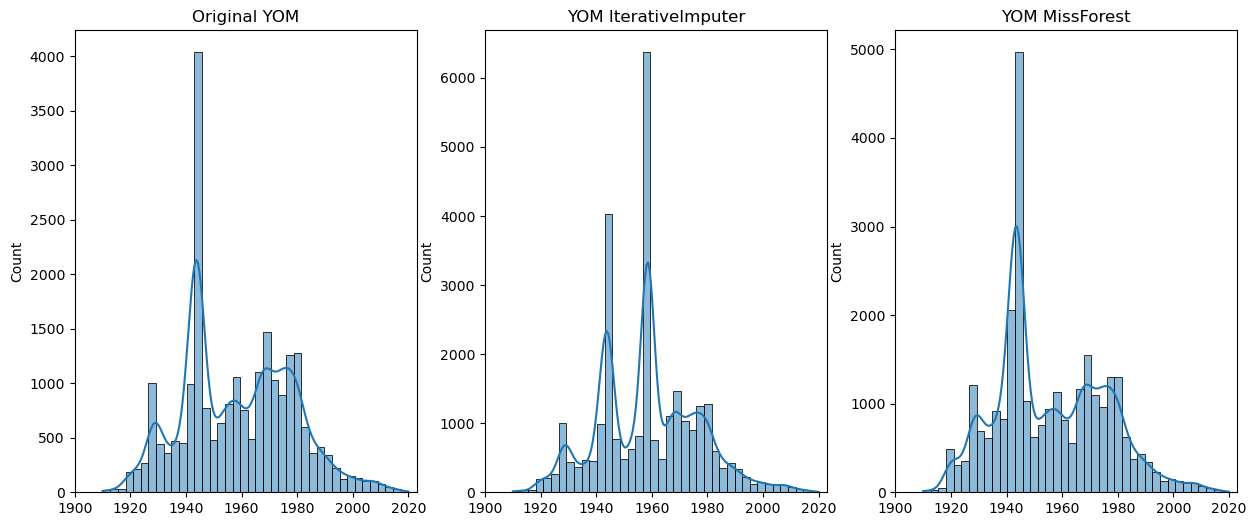

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(131)
sns.histplot(data.YOM, kde=True, bins=40)
plt.xlim([1900,2023])
plt.title('Original YOM')
plt.xlabel(None)

plt.subplot(132)
sns.histplot(traindatafill[1], kde=True, bins=40)
plt.xlim([1900,2023])
plt.title('YOM IterativeImputer')
plt.xlabel(None)

plt.subplot(133)
sns.histplot(data_imp[0], kde=True, bins=40)
plt.xlim([1900,2023])
plt.title('YOM MissForest')
plt.xlabel(None)
plt.show()

We copy the data predicted by the MissForest algorithm to our original dataset, adjust data types accordingly and recalculate the ```Age``` column.

In [ ]:
data['YOM'] = data_imp[0]
data['Crew on board'] = data_imp[1]
data['Crew fatalities'] = data_imp[2]
data['Pax on board'] = data_imp[3]
data['PAX fatalities'] = data_imp[4]
data['Other fatalities'] =data_imp[5]
data['Total fatalities'] = data_imp[6]

data = data.astype({'YOM' : 'int',
                    'Crew on board' : 'int',
                    'Crew fatalities' : 'int',
                    'Pax on board' : 'int',
                    'PAX fatalities' : 'int',
                    'Other fatalities' : 'int',
                    'Total fatalities' : 'int',
                    'Year' : 'int',
                    })

data.drop(columns='Aircraft_cod', inplace=True)
data['Age'] = data['Year'] - data['YOM']

We check for missing values, and find none.

In [ ]:
data.isna().sum()

Date                0
Aircraft            0
Operator            0
Flight phase        0
Flight type         0
Survivors           0
Crash site          0
Schedule            0
YOM                 0
Crash location      0
Country             0
Region              0
Crew on board       0
Crew fatalities     0
Pax on board        0
PAX fatalities      0
Other fatalities    0
Total fatalities    0
Circumstances       0
Crash cause         0
Year                0
Month               0
Weekday             0
Age                 0
dtype: int64

We subset for rows with ```Crew on board``` lower than ```Crew fatalities```, which is impossible.

In [ ]:
data.loc[data['Crew on board'] < data['Crew fatalities']]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age
2438,1934-08-10,Sikorsky S-38,China National Aviation Corporation - CNAC,Flight,Scheduled Revenue Flight,Yes,"Lake, Sea, Ocean, River",Unknown,1929,Ningbo Zhejiang,...,0,0,0,1,Crashed in unknown circumstances in the Bay of...,Unknown,1934,August,Friday,5
2738,1936-02-14,Sikorsky S-41,SCADTA - Sociedad Colombo-Alemana de Transport...,Unknown,Scheduled Revenue Flight,Yes,"Lake, Sea, Ocean, River",Unknown,1934,Barranquilla Atlántico,...,0,1,0,2,The float plane christened 'Alfonso Lopez' cra...,Unknown,1936,February,Friday,2
3038,1937-08-05,Unnamed aircraft,Japan Air Transport,Takeoff (climb),Cargo,Unknown,Airport (less than 10 km from airport),Unknown,1933,Tokyo-Haneda Kanto,...,0,0,0,1,"On takeoff from Tokyo-Haneda Airport, the airc...",Unknown,1937,August,Thursday,4
3804,1940-07-14,Bristol 130 Bombay,Royal Air Force - RAF,Landing (descent or approach),Supply,Yes,Airport (less than 10 km from airport),Tobruk - Heliopolis,1933,Heliopolis Cairo,...,0,0,0,1,"Following a supply mission from Tobruk, the ai...",Unknown,1940,July,Sunday,7
4028,1941-02-09,Consolidated PBY-5A Catalina,United States Navy - USN,Landing (descent or approach),Training,Yes,"Lake, Sea, Ocean, River",Unknown,1936,North Island-Halsey Field NAS (San Diego) Cali...,...,0,0,0,1,The seaplane water looped on landing and came ...,Unknown,1941,February,Sunday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13201,1963-07-16,Antonov AN-12,Indian Air Force - Bharatiya Vayu Sena,Landing (descent or approach),Military,No,Airport (less than 10 km from airport),Unknown,1962,New Delhi-Palam National Capital Territory of ...,...,0,0,0,2,Crash landed at Palam Airport. At least two cr...,Unknown,1963,July,Tuesday,1
13569,1965-01-14,Douglas C-47 Skytrain (DC-3),Turkish Air Force - Türk Hava Kuvvetleri,Takeoff (climb),Military,Yes,Airport (less than 10 km from airport),Unknown,1944,Istanbul-Yesilköy Marmara Region (Marmara Bölg...,...,0,0,0,1,"At liftoff, the airplane went out of control a...",Unknown,1965,January,Thursday,21
13684,1965-06-15,Nord 2501 Noratlas,French Air Force - Armée de l'Air,Unknown,Military,Yes,Airport (less than 10 km from airport),Unknown,1946,Fderik Tiris Zemmour,...,0,0,0,1,Crashed in unknown circumstances in Fort Goura...,Unknown,1965,June,Tuesday,19
18228,1978-10-07,Britten-Norman Islander,Acme Plywood %26 Veneer Company,Flight,Executive/Corporate/Business,Yes,Mountains,Unknown,1976,Divilacan Cagayan,...,8,6,0,11,"While cruising in thunderstorm activity, the t...",Weather,1978,October,Saturday,2


Since none of the crashes involves unmanned aircrafts (drones), the minimum value for ```Crew on board``` is 1 (a pilot); so we replace the 0s with 1s.

In [ ]:
data.loc[data['Crew on board'] == 0, 'Crew on board'] = 1

We recheck for rows with ```Crew on board``` lower than ```Crew fatalities``` and find a few rows.

In [ ]:
data.loc[data['Crew on board'] < data['Crew fatalities']]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age
5173,1943-03-02,Lisunov LI-2,Soviet Air Force - Voyenno-vozdushnye sily CCCP,Landing (descent or approach),Military,Yes,Mountains,Astrakhan – Chkalovsk,1942,Sol-Iletsk Orenburg oblast,...,0,0,0,9,"While flying from Astrakhan to Chkalovsk, the ...",Unknown,1943,March,Tuesday,1
5569,1943-08-25,Consolidated B-24 Liberator,United States Army Air Forces - USAAF,Landing (descent or approach),Military,Yes,Airport (less than 10 km from airport),Unknown,1943,Fenton Northern Territory,...,0,0,0,4,"Crashed on landing in unknown circumstances, k...",Unknown,1943,August,Wednesday,0
6196,1944-05-14,Douglas C-47 Skytrain (DC-3),United States Army Air Forces - USAAF,Flight,Military,Yes,"Plain, Valley",Unknown,1944,Gaudo Molise,...,0,0,0,2,"In unknown circumstances, a collision involvin...",Unknown,1944,May,Sunday,0
6790,1944-12-28,Handley Page H.P.57 Halifax III,Royal Air Force - RAF,Parking,Bombing,Yes,Airport (less than 10 km from airport),Elvington - Elvington,1943,Elvington Yorkshire,...,0,0,0,13,While being prepared for a bombing mission ove...,"Terrorism act, Hijacking, Sabotage",1944,December,Thursday,1
6870,1945-01-28,Consolidated PBY-5A Catalina,United States Navy - USN,Flight,Military,Unknown,"Plain, Valley",Unknown,1944,Greece All Greece,...,0,0,0,2,While flying at low height along a railroad tr...,Human factor,1945,January,Sunday,1
13201,1963-07-16,Antonov AN-12,Indian Air Force - Bharatiya Vayu Sena,Landing (descent or approach),Military,No,Airport (less than 10 km from airport),Unknown,1962,New Delhi-Palam National Capital Territory of ...,...,0,0,0,2,Crash landed at Palam Airport. At least two cr...,Unknown,1963,July,Tuesday,1
18228,1978-10-07,Britten-Norman Islander,Acme Plywood %26 Veneer Company,Flight,Executive/Corporate/Business,Yes,Mountains,Unknown,1976,Divilacan Cagayan,...,8,6,0,11,"While cruising in thunderstorm activity, the t...",Weather,1978,October,Saturday,2


We correct the ```Crew on board``` values, using the ```Circumstances``` column as guidance.

In [ ]:
data.iloc[5173,12] = 9
data.iloc[5569,12] = 4
data.iloc[6196,12] = 2
data.iloc[6790,12] = 13
data.iloc[6870,12] = 2
data.iloc[13201,12] = 2
data.iloc[18228,12] = 5

We repeat the process for ```Pax on board``` and ```PAX fatalities``` columns.

In [ ]:
data.loc[data['Pax on board'] < data['PAX fatalities']]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Pax on board,PAX fatalities,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age
2738,1936-02-14,Sikorsky S-41,SCADTA - Sociedad Colombo-Alemana de Transport...,Unknown,Scheduled Revenue Flight,Yes,"Lake, Sea, Ocean, River",Unknown,1934,Barranquilla Atlántico,...,0,1,0,2,The float plane christened 'Alfonso Lopez' cra...,Unknown,1936,February,Friday,2
3011,1937-06-16,Junkers JU.52,South African Airways -SAA - Suid Afrikaanse L...,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Johannesburg – Port Elizabeth,1937,Johannesburg-Rand Gauteng,...,0,1,0,1,"Shortly after takeoff, engine number one and t...",Technical failure,1937,June,Wednesday,0
4304,1941-12-08,Douglas DC-2,Royal Air Force - RAF,Flight,Military,Yes,Desert,Unknown,1935,Hamata Red Sea,...,0,1,0,1,The aircraft was shot down by three German Mes...,"Terrorism act, Hijacking, Sabotage",1941,December,Monday,6
4333,1941-12-29,Short S.23 Empire Flying Boat,British Overseas Airways Corporation - BOAC,Takeoff (climb),Scheduled Revenue Flight,Unknown,"Lake, Sea, Ocean, River",Unknown,1935,Sabang Aceh,...,0,4,0,4,"While taking off from bay of Sabang, the seapl...",Other causes,1941,December,Monday,6
4426,1942-02-19,Douglas DC-2,China National Aviation Corporation - CNAC,Flight,Scheduled Revenue Flight,Yes,"Plain, Valley",Unknown,1939,Zhengzhou-Xinzheng Henan,...,0,1,0,1,At least one person was killed when the aircra...,Unknown,1942,February,Thursday,3
6478,1944-08-22,Travel Air 6000,Lineas Aéreas Mineras - LAMSA,Flight,Scheduled Revenue Flight,Unknown,"Plain, Valley",Unknown,1942,Pánuco Sinaloa,...,0,1,0,2,Crashed in unknown circumstances some 16 km no...,Unknown,1944,August,Tuesday,2
7744,1946-07-08,Consolidated PBY-5A Catalina,Royal Norwegian Air Force - Kongelige Norske L...,Landing (descent or approach),Military,Yes,"Lake, Sea, Ocean, River",Unknown,1943,Alta Finnmark,...,0,3,0,3,"Crashed and sank off Alta, in Altafjorden, due...",Unknown,1946,July,Monday,3
8727,1949-01-07,Breguet 730,French Navy,Flight,Military,Yes,"Lake, Sea, Ocean, River",Unknown,1944,Arzew Oran,...,0,2,0,2,While overflying the Mediterranean Sea on a fl...,Technical failure,1949,January,Friday,5
9227,1950-06-23,Douglas C-47 Skytrain (DC-3),Transportes Aéreos de Jalisco,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Guadalajara – Puerto Vallarta,1944,Guadalajara Jalisco,...,0,3,0,4,The aircraft crashed in unknown circumstances ...,Unknown,1950,June,Friday,6
10660,1953-10-13,SNCASO SO.30 Bretagne,Royal Air Maroc - RAM,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Tangier – Casablanca,1945,Tangier-Boukhalef Tangier-Tétouan,...,0,1,0,1,Shortly after takeoff from Tangier-Boukhalef A...,Technical failure,1953,October,Tuesday,8


And correct the ```Pax on board``` values.

In [ ]:
data.iloc[2738, 14] = 1
data.iloc[3011, 14] = 1
data.iloc[4304, 14] = 1
data.iloc[4333, 14] = 4
data.iloc[4426, 14] = 1
data.iloc[6478, 14] = 1
data.iloc[7744, 14] = 3
data.iloc[8727, 14] = 2
data.iloc[9227, 14] = 3
data.iloc[10660, 14] = 1
data.iloc[13008, 14] = 44
data.iloc[16428, 14] = 56
data.iloc[20017, 14] = 1
data.iloc[21393, 14] = 90
data.iloc[25938, 14] = 5
data.iloc[27953, 14] = 1

# EDA

Plotting the number of crashes by year, we find a peak around 1944. This is most likely because of WWII.

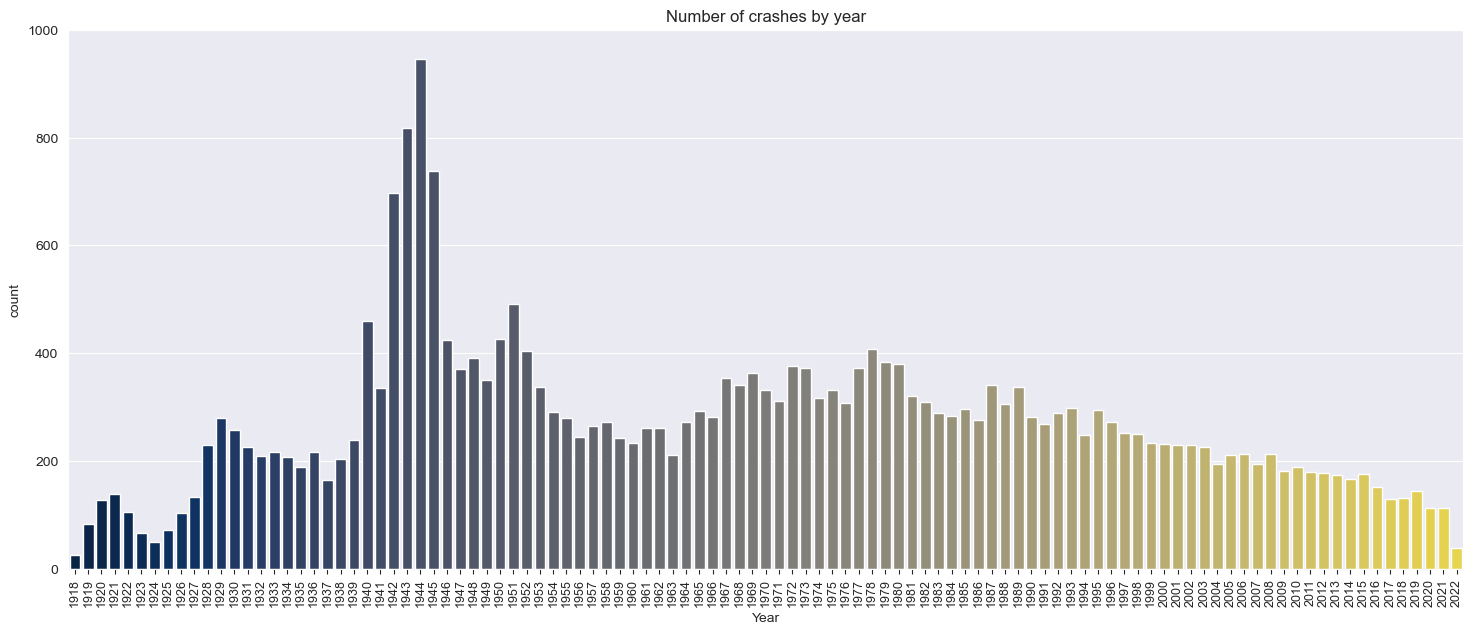

In [ ]:
sns.set_style("darkgrid")
ax, fig = plt.subplots(figsize=(18,7))
ax = sns.countplot(data=data, x='Year', palette='cividis', hue='Year', legend=False)
ax.tick_params(axis='x', labelrotation = 90, bottom=True, labelsize=9)
ax.yaxis.set_ticks(np.arange(0, 1200, 200))
ax.set_title('Number of crashes by year')
plt.show()

We will check our theory: we subset for WWII years (1939 - 1945) and find the top 10 most crashed aircrafts during that time.

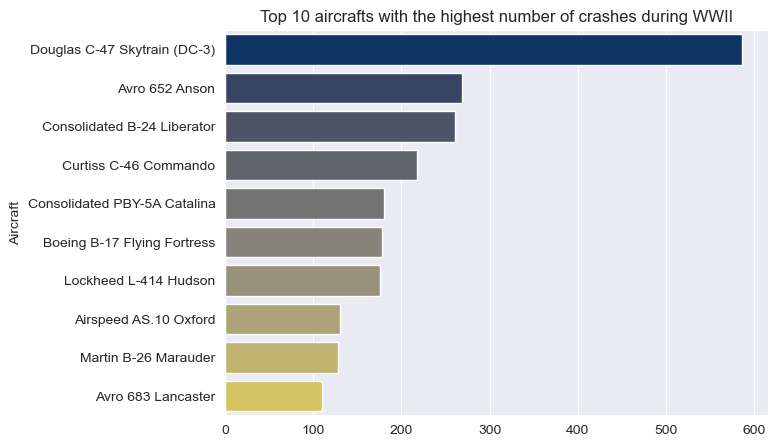

In [ ]:
_39_to_45 = data[data['Date'].dt.year.between(1939, 1945)]['Aircraft'].value_counts()

plt.figure(figsize=(7,5))
sns.barplot(y=_39_to_45[0:10].index, x=_39_to_45[0:10].values, palette='cividis', hue=_39_to_45[0:10].index, legend=False)
plt.title('Top 10 aircrafts with the highest number of crashes during WWII')
plt.show()

If we take a look at that list and search for those models, we find that all of them are either military aircrafts, or civil-repurposed ones for military activities such as training or patroling.

In [ ]:
_39_to_45[0:10].index

Index(['Douglas C-47 Skytrain (DC-3)', 'Avro 652 Anson',
       'Consolidated B-24 Liberator', 'Curtiss C-46 Commando',
       'Consolidated PBY-5A Catalina', 'Boeing B-17 Flying Fortress',
       'Lockheed L-414 Hudson', 'Airspeed AS.10 Oxford',
       'Martin B-26 Marauder', 'Avro 683 Lancaster'],
      dtype='object', name='Aircraft')

To make a comparisson, we find the top 10 most crashed aircrafts throughout history.

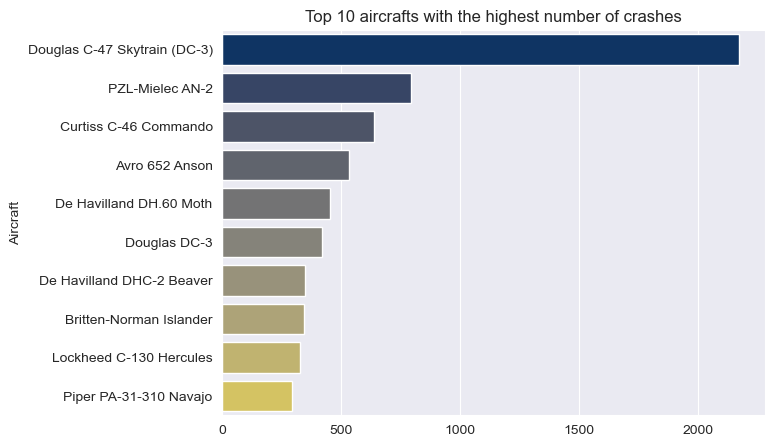

In [ ]:
Aircrafts = data.Aircraft.value_counts()[0:10]
plt.figure(figsize=(7,5))
sns.barplot(y=Aircrafts.index, x=Aircrafts.values, palette='cividis', hue=Aircrafts.index, legend=False)
plt.title('Top 10 aircrafts with the highest number of crashes')
plt.show()

Looking at this list, most of them are transport aircrafts, with only a few military ones.

In [ ]:
Aircrafts.index

Index(['Douglas C-47 Skytrain (DC-3)', 'PZL-Mielec AN-2',
       'Curtiss C-46 Commando', 'Avro 652 Anson', 'De Havilland DH.60 Moth',
       'Douglas DC-3', 'De Havilland DHC-2 Beaver', 'Britten-Norman Islander',
       'Lockheed C-130 Hercules', 'Piper PA-31-310 Navajo'],
      dtype='object', name='Aircraft')

Plotting the number of crashes by month, we find a peak in December. One might think that people tend to be more distracted because of the holidays.

C:\Users\leann\AppData\Local\Temp\ipykernel_22532\3580556955.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='Month', order=order, palette='cividis')


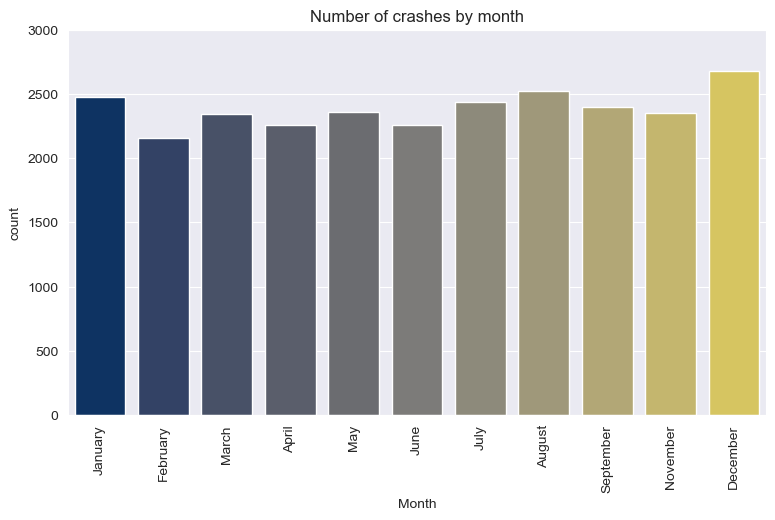

In [ ]:
order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December']

ax, fig = plt.subplots(figsize=(9,5))
ax = sns.countplot(data=data, x='Month', order=order, palette='cividis')
ax.tick_params(axis='x', labelrotation = 90)
ax.yaxis.set_ticks(np.arange(0, 3500, 500))
ax.set_title('Number of crashes by month')
plt.show()

Plotting the number of crashes by plane age, we find peaks in 1 and 2 years old planes, descending progressively after that.

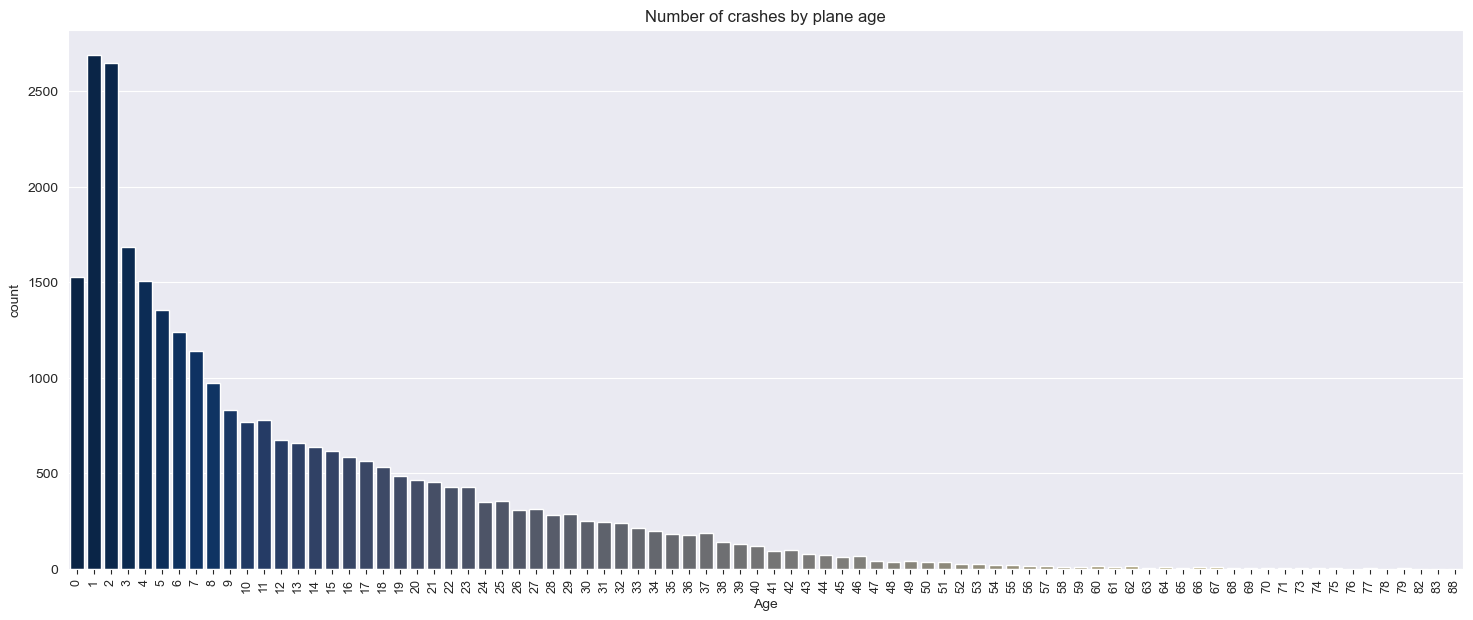

In [ ]:
ax, fig = plt.subplots(figsize=(18,7))
ax = sns.countplot(data=data, x='Age', palette='cividis', hue='Age', legend=False)
ax.tick_params(axis='x', labelrotation = 90, bottom=True, labelsize=9)
ax.set_title('Number of crashes by plane age')
plt.show()

Plotting the number of crashes by flight phase, we can see that most of them ocurr during Flight, Landing or Takeoff.

C:\Users\leann\AppData\Local\Temp\ipykernel_22532\1230090393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, y='Flight phase', palette='cividis', order=data['Flight phase'].value_counts().index)


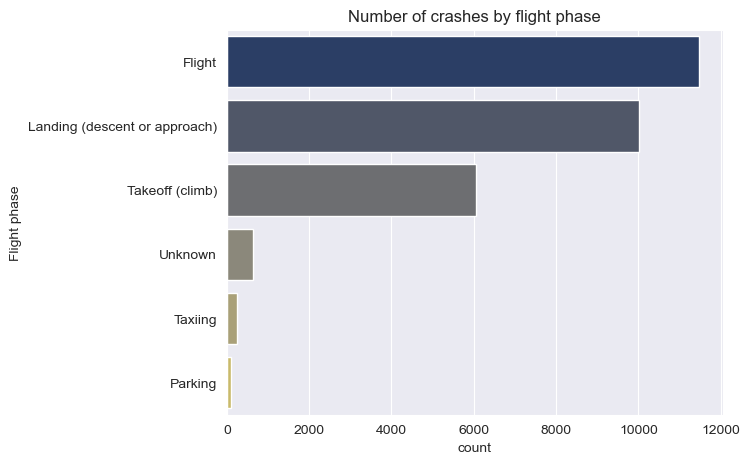

In [ ]:
ax, fig = plt.subplots(figsize=(6.4,5))
ax = sns.countplot(data=data, y='Flight phase', palette='cividis', order=data['Flight phase'].value_counts().index)
ax.set_title('Number of crashes by flight phase')
plt.show()

Plotting the number of crashes by crash cause, we can see that most of them are due to Human factor, followed by Unknown causes and Technical failure.

C:\Users\leann\AppData\Local\Temp\ipykernel_22532\3289616158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, y='Crash cause', palette='cividis', order=data['Crash cause'].value_counts().index)


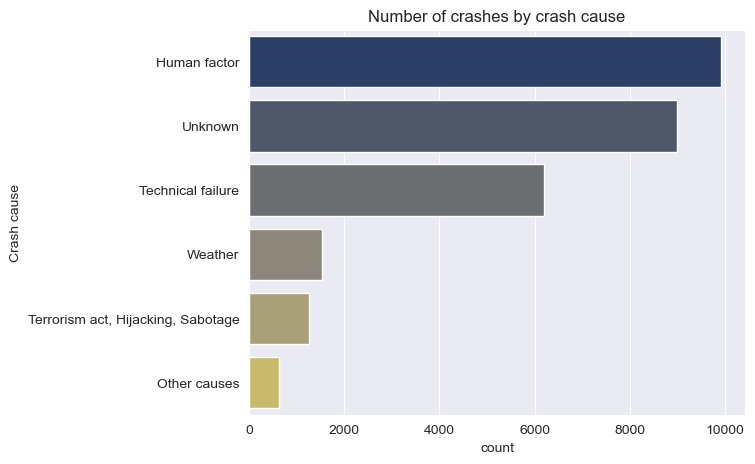

In [ ]:
ax, fig = plt.subplots(figsize=(6.4,5))
ax = sns.countplot(data=data, y='Crash cause', palette='cividis', order=data['Crash cause'].value_counts().index)
ax.set_title('Number of crashes by crash cause')
plt.show()

Plotting the number of crashes by region, most of them occur over North America, Europe and Asia. These regions, most likely have higher air traffic than the rest of them.

C:\Users\leann\AppData\Local\Temp\ipykernel_22532\2365904139.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, y='Region', palette='cividis', order=data['Region'].value_counts().index)


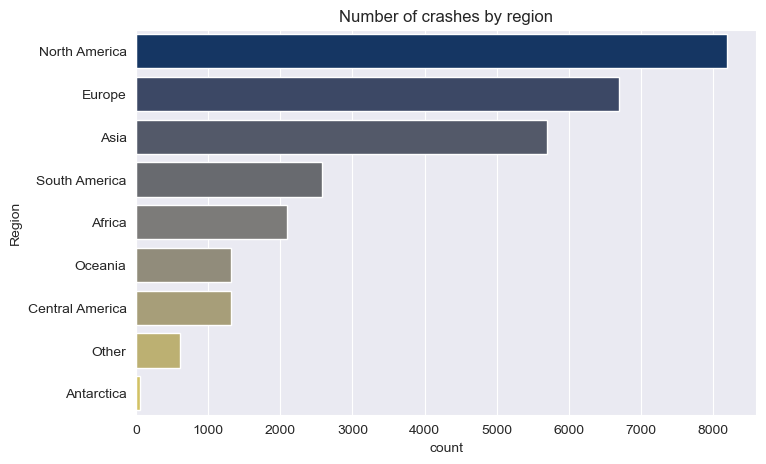

In [ ]:
ax, fig = plt.subplots(figsize=(8,5))
ax = sns.countplot(data=data, y='Region', palette='cividis', order=data['Region'].value_counts().index)
ax.set_title('Number of crashes by region')
plt.show()

We subset the number of crashes by country.

In [ ]:
country = data.groupby('Country').size().to_frame().reset_index().rename(columns={0: "count"})
country.head()

,Country,count
0,Afghanistan,102
1,Albania,2
2,Algeria,88
3,American Samoa,3
4,Angola,123


We then make a color map (which won't be visible in this static notebook).

In [ ]:
colorscale = ['rgb(0, 32, 81)', 'rgb(60, 77, 110)', 'rgb(127, 124, 117)', 'rgb(187, 175, 113)']
fig = px.choropleth(data_frame=country, locations='Country', locationmode='country names' ,color='count', color_continuous_scale=colorscale)
fig.show()

So we export the map to an image.

In [ ]:
img = fig.to_image(format="png", engine="kaleido")

And show it.

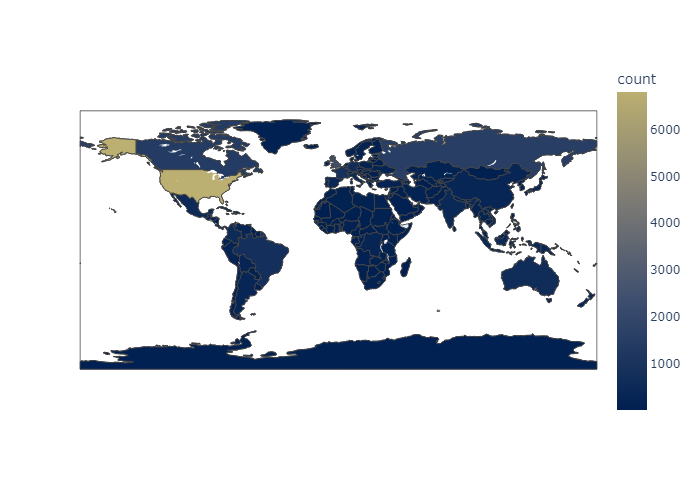

In [ ]:
Image(img)

The top 3 countries with the highest number of crashes are USA, UK and Russia.

In [ ]:
country.sort_values('count', ascending=False)[0:3]

,Country,count
209,United States of America,6804
208,United Kingdom,2389
160,Russia,1505


If we plot the number of crashes by site of occurrence, we can see the majority of them occur at the airport (or less than 10km from it).

C:\Users\leann\AppData\Local\Temp\ipykernel_22532\1295650593.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




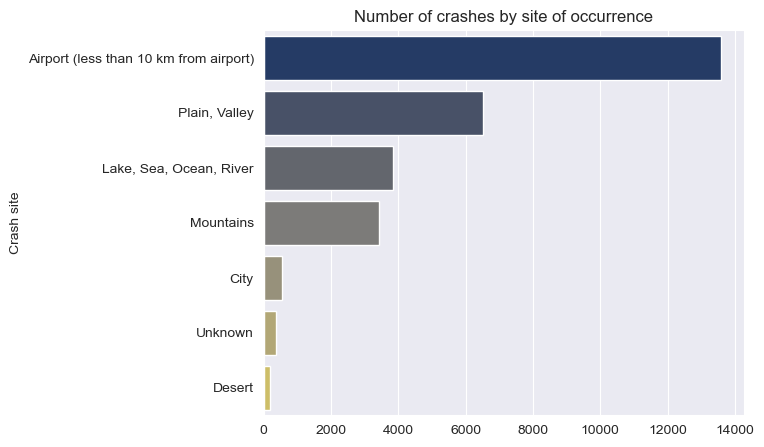

In [ ]:
sites = data['Crash site'].value_counts()
plt.figure(figsize=(6.2,5))
sns.barplot(y=sites.index, x=sites.values, palette='cividis')
plt.title('Number of crashes by site of occurrence')
plt.show()

In case of a plane crash, the probability of not surviving it are slightly higher.

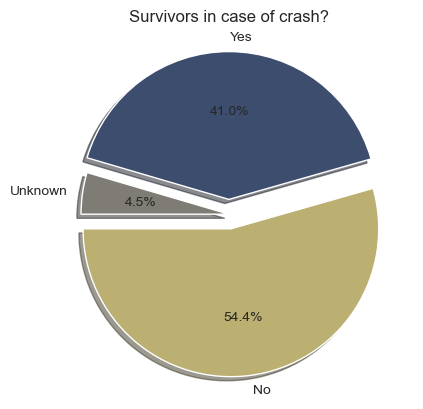

In [ ]:
explode = (0.1, 0.1, 0)

fig, ax = plt.subplots()
ax.pie(data.Survivors.value_counts(), explode=explode, labels=data.Survivors.unique(), autopct='%1.1f%%',
       shadow=True, startangle=180, colors=['#bbaf71', '#3c4d6e', '#7f7c75'])
ax.set_title('Survivors in case of crash?')
plt.show()

We will create 2 new features: the deceased rates for PAX and crew. The rates wil have a range of 0 - 1; 0 corresponding to the survival of the entire group, and 1 to the decease of all of them.

The PAX rate will have null values in cases of flights without passengers, so that these flights don't influence the rate.

In [ ]:
data['Crew_dcsd_rate'] = data['Crew fatalities']/data['Crew on board']
data['PAX_dcsd_rate'] = np.where(data['Pax on board'] == 0, np.NaN, data['PAX fatalities']/data['Pax on board'])

Based on historical records, the probability for the crew of either fully surviving or fully perishing in the event of a crash is around 45% for each case; the probability for the group to partially survive is around 10%.

The probability for the PAX of fully surviving is a little under 40%, and fully perishing is a little under 50%; partial survivability is around 15%.



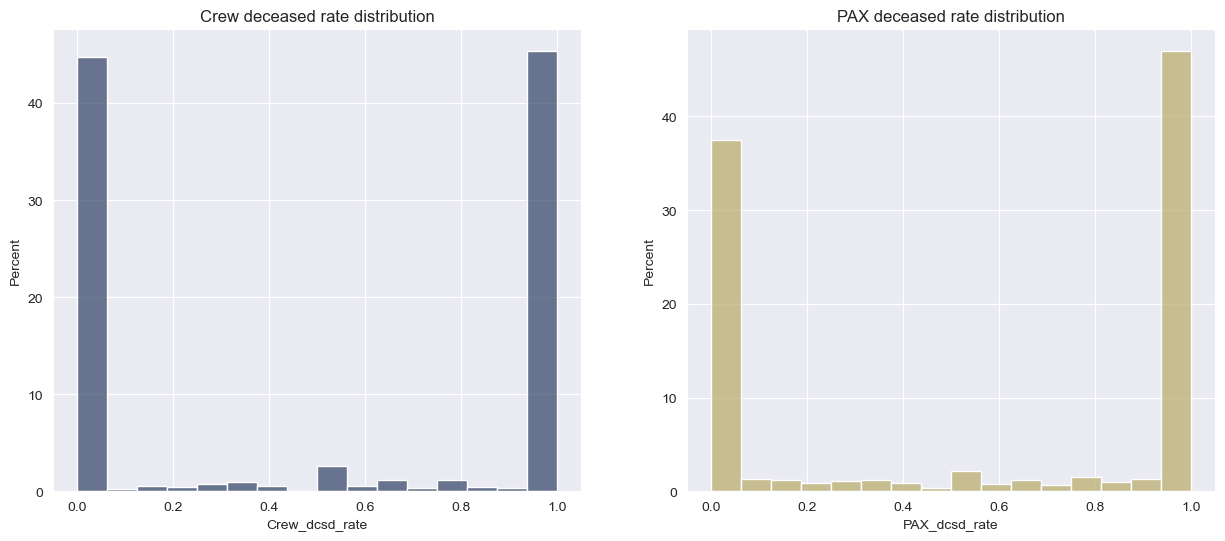

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.histplot(data['Crew_dcsd_rate'], bins=16, color='#3c4d6e', stat="percent")
plt.title('Crew deceased rate distribution')

plt.subplot(122)
sns.histplot(data['PAX_dcsd_rate'], bins=16, color='#bbaf71', stat="percent")
plt.title('PAX deceased rate distribution')
plt.show()

## Infamous plane crashes

We will search throughout history for infamous plane crashes and their details.

The most recent one that comes to my mind is the MH370; a Malaysian Airlines flight that went missing. There are several theories, but to this day, no one knows for certain what happened to it. There's a great Netflix series about it.

So we will subset for 'Malaysian Airlines' and years after '2000', since we don't know the exact date.

In [ ]:
data[(data['Operator'].str.contains('Malaysian Airlines')) & (data['Date'] > '2000')]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age,Crew_dcsd_rate,PAX_dcsd_rate
27406,2014-03-08,Boeing 777-200,Malaysian Airlines System - MAS,Flight,Scheduled Revenue Flight,No,"Lake, Sea, Ocean, River",Kuala Lumpur – Beijing,2002,Indian Ocean All World,...,0,239,The Boeing 777-2H6ER took off from Kuala Lumpu...,Unknown,2014,March,Saturday,12,1.0,1.0
27464,2014-07-17,Boeing 777-200,Malaysian Airlines System - MAS,Flight,Scheduled Revenue Flight,No,"Plain, Valley",Amsterdam – Kuala Lumpur,1997,Hrabove Donetsk Oblast,...,0,298,Flight MH17 departed the gate at Amsterdam-Sch...,"Terrorism act, Hijacking, Sabotage",2014,July,Thursday,17,1.0,1.0


We subset for index '27406', since the other result is a terrorist act.

In [ ]:
data.iloc[27406]

Date                                              2014-03-08 00:00:00
Aircraft                                               Boeing 777-200
Operator                              Malaysian Airlines System - MAS
Flight phase                                                   Flight
Flight type                                  Scheduled Revenue Flight
Survivors                                                          No
Crash site                                    Lake, Sea, Ocean, River
Schedule                                       Kuala Lumpur – Beijing
YOM                                                              2002
Crash location                                 Indian Ocean All World
Country                                                          None
Region                                                          Other
Crew on board                                                      12
Crew fatalities                                                    12
Pax on board        

And then select the ```Circumstances``` column.

In [ ]:
data.iloc[27406, 18]

'The Boeing 777-2H6ER took off from Kuala Lumpur Airport runway 32R at 0041LT bound for Beijing. Some 40 minutes later, while reaching FL350 over the Gulf of Thailand, radar contact was lost. At this time, the position of the aircraft was estimated 90 NM northeast of Kota Bharu, some 2 km from the IGARI waypoint. More than 4 days after the \'accident\', no trace of the aircraft has been found. On the fifth day of operation, several countries were involved in the SAR operations, in the Gulf of Thailand, west of China Sea and on the Malacca Strait as well. All operations are performed in coordination with China, Thailand, Vietnam, Malaysia and Philippines. No distress call or any kind of message was sent by the crew. The last ACARS message was received at 0107LT and did not contain any error, failure or technical problems. At 0119LT was recorded the last radio transmission with the crew saying "All right, good night". At 0121LT, the transponder was switched off and the last radar contact

We then search for the 09-11 terrorist attacks occurred in the US. So we subset for ```Date``` equal '2001-09-11'.

In [ ]:
data[data['Date'] == '2001-09-11']

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age,Crew_dcsd_rate,PAX_dcsd_rate
24918,2001-09-11,Boeing 757-200,United Airlines,Flight,Scheduled Revenue Flight,No,"Plain, Valley",Newark - San Francisco,1996,Shanksville Pennsylvania,...,0,45,The Boeing 757 departed Newark Airport at 0847...,"Terrorism act, Hijacking, Sabotage",2001,September,Tuesday,5,1.0,1.0
24919,2001-09-11,Boeing 757-200,American Airlines,Flight,Scheduled Revenue Flight,No,City,Washington - Los Angeles,1991,Washington DC District of Columbia,...,0,64,The Boeing 757 departed Washington-Dulles Airp...,"Terrorism act, Hijacking, Sabotage",2001,September,Tuesday,10,1.0,1.0
24920,2001-09-11,Boeing 767-200,United Airlines,Flight,Scheduled Revenue Flight,No,City,Boston - Los Angeles,1983,New York New York,...,0,65,The Boeing 767 departed Boston-Logan Airport a...,"Terrorism act, Hijacking, Sabotage",2001,September,Tuesday,18,1.0,1.0
24921,2001-09-11,Boeing 767-200,American Airlines,Flight,Scheduled Revenue Flight,No,City,Boston - Los Angeles,1987,New York New York,...,0,92,The Boeing 767 departed Boston-Logan at 0759LT...,"Terrorism act, Hijacking, Sabotage",2001,September,Tuesday,14,1.0,1.0


We subset for the first of the list.

In [ ]:
data.iloc[24918]

Date                                              2001-09-11 00:00:00
Aircraft                                               Boeing 757-200
Operator                                              United Airlines
Flight phase                                                   Flight
Flight type                                  Scheduled Revenue Flight
Survivors                                                          No
Crash site                                              Plain, Valley
Schedule                                       Newark - San Francisco
YOM                                                              1996
Crash location                               Shanksville Pennsylvania
Country                                      United States of America
Region                                                  North America
Crew on board                                                       7
Crew fatalities                                                     7
Pax on board        

This was the United 93 flight. There are several movies made about this particular flight.

In [ ]:
data.iloc[24918, 18]

'The Boeing 757 departed Newark Airport at 0847LT on a regular schedule service to San Francisco, carrying 37 passengers and a crew of seven. Few minutes later, the aircraft was hijacked by terrorists who modified the flight path and apparently attempted to fly over Washington DC. At 1030LT, the aircraft crashed in an open field located about 4 km north of Shanksville. The aircraft disintegrated on impact and all 45 occupants were killed. The terrorist attacks of September 11, 2001 are under the jurisdiction of the Federal Bureau of Investigation. The Safety Board provided requested technical assistance to the FBI, and this material generated by the NTSB is under the control of the FBI. The Safety Board does not plan to issue a report or open a public docket.'

We subset for the second one of the list.

In [ ]:
data.iloc[24919]

Date                                              2001-09-11 00:00:00
Aircraft                                               Boeing 757-200
Operator                                            American Airlines
Flight phase                                                   Flight
Flight type                                  Scheduled Revenue Flight
Survivors                                                          No
Crash site                                                       City
Schedule                                     Washington - Los Angeles
YOM                                                              1991
Crash location                     Washington DC District of Columbia
Country                                      United States of America
Region                                                  North America
Crew on board                                                       6
Crew fatalities                                                     6
Pax on board        

This flight was crashed on one side of the Pentagon.

In [ ]:
data.iloc[24919, 18]

'The Boeing 757 departed Washington-Dulles Airport at 0810LT on a regular schedule service to Los Angeles, carrying 58 passengers and a crew of six. Few minutes later, the aircraft was hijacked by terrorists who modified the flight path and flew direct over Washington DC. At 0945LT, the aircraft crashed on the southwest side of the Pentagon building. The aircraft disintegrated on impact and all 64 occupants were killed. The terrorist attacks of September 11, 2001 are under the jurisdiction of the Federal Bureau of Investigation. The Safety Board provided requested technical assistance to the FBI, and this material generated by the NTSB is under the control of the FBI. The Safety Board does not plan to issue a report or open a public docket.'

We subset for the third of the list.

In [ ]:
data.iloc[24920]

Date                                              2001-09-11 00:00:00
Aircraft                                               Boeing 767-200
Operator                                              United Airlines
Flight phase                                                   Flight
Flight type                                  Scheduled Revenue Flight
Survivors                                                          No
Crash site                                                       City
Schedule                                         Boston - Los Angeles
YOM                                                              1983
Crash location                                      New York New York
Country                                      United States of America
Region                                                  North America
Crew on board                                                       9
Crew fatalities                                                     9
Pax on board        

This flight was crashed on the South tower of the WTC.

In [ ]:
data.iloc[24920, 18]

'The Boeing 767 departed Boston-Logan Airport at 0814LT on a regular schedule service to Los Angeles, carrying 56 passengers and a crew of nine. Few minutes later, the aircraft was hijacked by terrorists who modified the flight path and flew direct over New York. At 0903LT, the aircraft struck the South Tower of the World Trade Center, between 78th and 84th floor. The aircraft disintegrated on impact and all 65 occupants were killed. The tower later collapsed. The terrorist attacks of September 11, 2001 are under the jurisdiction of the Federal Bureau of Investigation. The Safety Board provided requested technical assistance to the FBI, and this material generated by the NTSB is under the control of the FBI. The Safety Board does not plan to issue a report or open a public docket.'

We subset for the fourth of the list.

In [ ]:
data.iloc[24921]

Date                                              2001-09-11 00:00:00
Aircraft                                               Boeing 767-200
Operator                                            American Airlines
Flight phase                                                   Flight
Flight type                                  Scheduled Revenue Flight
Survivors                                                          No
Crash site                                                       City
Schedule                                         Boston - Los Angeles
YOM                                                              1987
Crash location                                      New York New York
Country                                      United States of America
Region                                                  North America
Crew on board                                                      11
Crew fatalities                                                    11
Pax on board        

This flight was crashed on the North tower of the WTC.

In [ ]:
data.iloc[24921, 18]

'The Boeing 767 departed Boston-Logan at 0759LT on a regular schedule service to Los Angeles, carrying 81 passengers and a crew of 11. Few minutes later, the aircraft was hijacked by terrorists who modified the flight path and flew direct over New York. At 0845LT, the aircraft struck the North Tower of the World Trade Center, between 94th and 99th floor. The aircraft disintegrated on impact and all 92 occupants were killed. The tower later collapsed. The terrorist attacks of September 11, 2001 are under the jurisdiction of the Federal Bureau of Investigation. The Safety Board provided requested technical assistance to the FBI, and this material generated by the NTSB is under the control of the FBI. The Safety Board does not plan to issue a report or open a public docket.'

Finally, as a kid, i remember an accident which took place in my hometown, Buenos Aires, Argentina involving a flight operated by 'LAPA'; commonly referred to as the 'LAPA tragedy'.

So we subset for operators containing 'LAPA'.

In [ ]:
data[data['Operator'].str.contains('LAPA')]

,Date,Aircraft,Operator,Flight phase,Flight type,Survivors,Crash site,Schedule,YOM,Crash location,...,Other fatalities,Total fatalities,Circumstances,Crash cause,Year,Month,Weekday,Age,Crew_dcsd_rate,PAX_dcsd_rate
13916,1966-03-06,Lockheed L-1049 Super Constellation,Lineas Aéreas Patagonicas Argentinas - LAPA,Landing (descent or approach),Delivery,Yes,"Lake, Sea, Ocean, River",Oakland – Lima – Buenos Aires,1952,Lima-Callao-Jorge Chávez Lima,...,0,0,The aircraft was on a delivery flight from Oak...,Technical failure,1966,March,Sunday,14,0.0,NaN
24438,1999-08-31,Boeing 737-200,Lineas Aéreas Privadas Argentinas - LAPA,Takeoff (climb),Scheduled Revenue Flight,Yes,Airport (less than 10 km from airport),Buenos Aires – Córdoba,1970,Buenos Aires-Aeroparque-Jorge Newbery Buenos A...,...,2,65,LAPA flight 3142 was scheduled to depart from ...,Human factor,1999,August,Tuesday,29,0.6,0.631579


The crash took place in the 90s, so we subset for the second one of the list.

In [ ]:
data.iloc[24438]

Date                                              1999-08-31 00:00:00
Aircraft                                               Boeing 737-200
Operator                     Lineas Aéreas Privadas Argentinas - LAPA
Flight phase                                          Takeoff (climb)
Flight type                                  Scheduled Revenue Flight
Survivors                                                         Yes
Crash site                     Airport (less than 10 km from airport)
Schedule                                       Buenos Aires – Córdoba
YOM                                                              1970
Crash location      Buenos Aires-Aeroparque-Jorge Newbery Buenos A...
Country                                                     Argentina
Region                                                  South America
Crew on board                                                       5
Crew fatalities                                                     3
Pax on board        

These are the details.

In [ ]:
data.iloc[24438, 18]

'LAPA flight 3142 was scheduled to depart from Buenos Aires-Jorge Newbery Airport at 20:36 for a 1 hour and 15 minute flight to Córdoba, Argentina. The first officer and cabin crew were the first to arrive at the Boeing 737-200. The first officer notified one of the mechanics that the total fuel requirement was 8,500 kg, all to be stored in the wing tanks. The mechanic noticed there was still some fuel in the central tank and commenced transferring the fuel from the central to the wing tanks. At that moment the captain boarded the flight. He threw his paperwork on the ground, showing annoyance, confirming that attitude by later shutting off the fuel transfer between the main tank and the wing tanks. During their first four minutes on board, the captain, the co-pilot and the purser talked about trivial matters in good spirits, focusing on the purser\'s personal issues. When the purser left the cockpit, the conversation changed tone as they discussed a controversial situation about the f